# 自动编码器
自动编码器最开始是作为一种数据压缩方法，同时还可以在卷积网络中进行逐层预训练，但是随后更多结构复杂的网络，比如 resnet 的出现使得我们能够训练任意深度的网络，自动编码器就不再使用在这个方面，下面我们讲一讲自动编码器的一个新的应用，这是随着生成对抗模型而出现的，就是使用自动编码器生成数据。

自动编码器的一般结构如下

![](https://ws1.sinaimg.cn/large/006tNc79ly1fmzr05igw3j30ni06j3z4.jpg)

由上面的图片，我们能够看到，第一部分是编码器(encoder)，第二部分是解码器(decoder)，编码器和解码器都可以是任意的模型，通常我们可以使用神经网络作为我们的编码器和解码器，输入的数据经过神经网络降维到一个编码，然后又通过另外一个神经网络解码得到一个与原始数据一模一样的生成数据，通过比较原始数据和生成数据，希望他们尽可能接近，所以最小化他们之间的差异来训练网络中编码器和解码器的参数。

当训练完成之后，我们如何生成数据呢？非常简单，我们只需要拿出解码器的部分，然后随机传入 code，就可以通过解码器生成各种各样的数据

![](https://ws3.sinaimg.cn/large/006tNc79ly1fmzrx3d3ygj30nu06ijs2.jpg)

下面我们使用 mnist 数据集来说明一个如何构建一个简单的自动编码器

In [1]:
import os
import torch
from torch.autograd import Variable
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms as tfs
from torchvision.utils import save_image #保存图片到本地

In [4]:
im_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # 标准化
])

train_set = MNIST('./mnist', transform=im_tfs,download=True)
train_data = DataLoader(train_set, batch_size=128, shuffle=True)

Processing...
Done!


In [7]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder,self).__init__()
        self.encoder=nn.Sequential(nn.Linear(28*28,128),
                                  nn.ReLU(True),
                                  nn.Linear(128,64),
                                  nn.ReLU(True),
                                  nn.Linear(64,12),
                                  nn.ReLU(True),
                                  nn.Linear(12,3))#输出的code是3维,便于可视化
        self.decoder=nn.Sequential(nn.Linear(3,12),
                                  nn.ReLU(True),
                                  nn.Linear(12,64),
                                  nn.ReLU(True),
                                  nn.Linear(64,128),
                                  nn.ReLU(True),
                                  nn.Linear(128,28*28),
                                  nn.Tanh())
    def forward(self,x):
        encode=self.encoder(x)
        decode=self.decoder(encode)
        return encode,decode

In [8]:
net=autoencoder()
x=Variable(torch.randn(1,28*28))#batch是1
code,_=net(x)
print(code.shape)

torch.Size([1, 3])


In [10]:
criterion=nn.MSELoss(reduction='sum')
optimizer=torch.optim.Adam(net.parameters(),lr=1e-3)

def to_img(x):
    x=0.5*(x+1.)
    x=x.clamp(0,1)
    x=x.view(x.shape[0],1,28,28)
    return x

In [12]:
# 开始训练自动编码器
for e in range(100):
    for im, _ in train_data:
        im = im.view(im.shape[0], -1)
        im = Variable(im)
        # 前向传播
        _, output = net(im)
        loss = criterion(output, im) / im.shape[0] # 平均
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (e+1) % 20 == 0: # 每 20 次，将生成的图片保存一下
        print('epoch: {}, Loss: {:.4f}'.format(e + 1, loss.item()))
        pic = to_img(output.cpu().data)
        if not os.path.exists('./simple_autoencoder'):
            os.mkdir('./simple_autoencoder')
        save_image(pic, './simple_autoencoder/image_{}.png'.format(e + 1))

epoch: 20, Loss: 96.7634
epoch: 40, Loss: 104.5215
epoch: 60, Loss: 92.5511
epoch: 80, Loss: 92.0029
epoch: 100, Loss: 103.5467


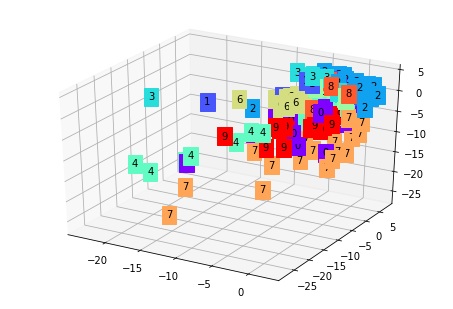

In [15]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

#可视化结果
view_data=Variable((train_set.train_data[:200].type(torch.FloatTensor).view(-1, 28*28) / 255. - 0.5) / 0.5)
encode,_=net(view_data)
fig=plt.figure(2)
ax=Axes3D(fig)
#x,y,z的数据值
X = encode.data[:, 0].numpy()
Y = encode.data[:, 1].numpy()
Z = encode.data[:, 2].numpy()
values=train_set.train_labels[:200].numpy()#标签值
for x,y,z,s in zip(X,Y,Z,values):
    c=cm.rainbow(int(255*s/9))
    ax.text(x,y,z,s,backgroundcolor=c)#标位子
ax.set_xlim(X.min(),X.max())
ax.set_ylim(Y.min(),Y.max())
ax.set_zlim(Z.min(),Z.max())
plt.show()

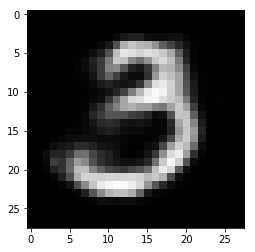

In [20]:
code=Variable(torch.FloatTensor([[1.19,-3.36,2.06]]))
decode=net.decoder(code)
decode_img=to_img(decode).squeeze()
decode_img=decode_img.data.numpy()*255

plt.imshow(decode_img.astype('uint8'),cmap='gray') #生成图片3

In [21]:
class conv_autoencoder(nn.Module):
    def __init__(self):
        super(conv_autoencoder,self).__init__()
        self.encoder=nn.Sequential(nn.Conv2d(1,16,3,stride=3,padding=1), #(b,16,10,10)
                                  nn.ReLU(True),
                                  nn.MaxPool2d(2,stride=2),#(b,16,5,5)
                                  nn.Conv2d(16,8,3,stride=2,padding=1),#(b,8,3,3)
                                  nn.ReLU(True),
                                  nn.MaxPool2d(2,stride=1))#(b,8,2,2)
        self.decoder=nn.Sequential(nn.ConvTranspose2d(8,16,3,stride=2),#(b,16,5,5)反卷积操作,可通过计算卷积方程式带入x求出反卷积后的大小
                                  nn.ReLU(True),
                                  nn.ConvTranspose2d(16,8,5,stride=3,padding=1),#(b,8,15,15)
                                  nn.ReLU(True),
                                  nn.ConvTranspose2d(8,1,2,stride=2,padding=1),#(b,1,28,28)
                                  nn.Tanh())
    def forward(self,x):
        encode=self.encoder(x)
        decode=self.decoder(encode)
        return encode,decode

In [22]:
conv_net=conv_autoencoder()
if torch.cuda.is_available():
    conv_net=conv_net.cuda()
optimizer=torch.optim.Adam(conv_net.parameters(),lr=1e-3,weight_decay=1e-5)#加入了l2正则

In [23]:
# 开始训练自动编码器
for e in range(40):
    for im, _ in train_data:
        if torch.cuda.is_available():
            im = im.cuda()
        im = Variable(im)
        # 前向传播
        _, output = conv_net(im)
        loss = criterion(output, im) / im.shape[0] # 平均
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (e+1) % 20 == 0: # 每 20 次，将生成的图片保存一下
        print('epoch: {}, Loss: {:.4f}'.format(e+1, loss.item()))
        pic = to_img(output.cpu().data)
        if not os.path.exists('./conv_autoencoder'):
            os.mkdir('./conv_autoencoder')
        save_image(pic, './conv_autoencoder/image_{}.png'.format(e+1))

epoch: 20, Loss: 84.7989
epoch: 40, Loss: 70.8376
